In [1]:
from transformer_lens import HookedTransformer  # type: ignore

/Users/oliclive-griffin/code/norms-post/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = HookedTransformer.from_pretrained("gpt2")

Loaded pretrained model gpt2 into HookedTransformer


In [3]:
out, cache = model.run_with_cache("Hello, how are you?")
out

tensor([[[ 7.5261, 11.1214,  7.8919,  ..., -3.1299, -3.3873,  8.5934],
         [12.6877,  5.6732,  1.4202,  ..., -0.1857, -0.5829,  5.4394],
         [ 7.0628,  2.4974,  1.9990,  ...,  0.3997, -1.0289,  6.9055],
         ...,
         [ 6.5808,  3.6308,  1.8215,  ...,  0.2447, -2.9500,  4.3658],
         [12.5154,  6.8293,  3.7944,  ..., -1.0004, -1.5481,  5.7356],
         [ 7.2098,  5.7401,  5.0575,  ..., -2.3576, -2.5064,  9.5046]]],
       device='mps:0', grad_fn=<ViewBackward0>)

In [4]:
cache["blocks.6.hook_resid_post"].norm(dim=-1)

tensor([[3084.0552,  104.4712,   93.4986,   88.1998,   94.6973,   91.5668,
           95.4919]], device='mps:0')

In [5]:
model.blocks[6]

TransformerBlock(
  (ln1): LayerNormPre(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (ln2): LayerNormPre(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (attn): Attention(
    (hook_k): HookPoint()
    (hook_q): HookPoint()
    (hook_v): HookPoint()
    (hook_z): HookPoint()
    (hook_attn_scores): HookPoint()
    (hook_pattern): HookPoint()
    (hook_result): HookPoint()
  )
  (mlp): MLP(
    (hook_pre): HookPoint()
    (hook_post): HookPoint()
  )
  (hook_attn_in): HookPoint()
  (hook_q_input): HookPoint()
  (hook_k_input): HookPoint()
  (hook_v_input): HookPoint()
  (hook_mlp_in): HookPoint()
  (hook_attn_out): HookPoint()
  (hook_mlp_out): HookPoint()
  (hook_resid_pre): HookPoint()
  (hook_resid_mid): HookPoint()
  (hook_resid_post): HookPoint()
)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from generate_activations import ActivationAccumulator

# N = number of sequences
# S = sequence length
# D = d_model


def plot_histogram(norms_N: np.ndarray):
    mean_norm = np.mean(norms_N)
    std_norm = np.std(norms_N)

    plt.figure(figsize=(10, 6))
    plt.hist(norms_N, bins=300, density=True, alpha=0.75, range=(norms_N.min(), norms_N.max()))
    plt.axvline(mean_norm, color="r", linestyle="--", label=f"Mean: {mean_norm:.2f}")
    plt.axvline(mean_norm + std_norm, color="g", linestyle=":", label=f"±1 STD: {std_norm:.2f}")
    plt.axvline(mean_norm - std_norm, color="g", linestyle=":")
    plt.xlabel("Activation Norm (shifted)")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.show()
    plt.close()


def plot_histogram_bounded(norms_N: np.ndarray):
    plt.figure(figsize=(10, 6))
    plt.hist(norms_N, bins=100, density=True, alpha=0.75, range=(30, 120))
    plt.xlabel(f"Activation Norm (shifted) n={len(norms_N)}")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.show()
    plt.close()


def get_norms(activation_accumulator: ActivationAccumulator):
    activations_NSD = activation_accumulator.get_activations()
    N, S, D = activations_NSD.shape
    activations_ND = np.reshape(activations_NSD, (N * S, D))
    mean_activation_D = activations_ND.mean(axis=0)
    activations_ND_shift = activations_ND - mean_activation_D
    norms_centered_N = np.linalg.norm(activations_ND_shift, axis=1)
    return norms_centered_N

In [9]:
from generate_activations import DATA_DIR
acc = ActivationAccumulator.load(DATA_DIR / "activations139.npy")
norms_N = get_norms(acc)

allocating space for 27306 sequences of activations
Loaded 17919 sequences of activations


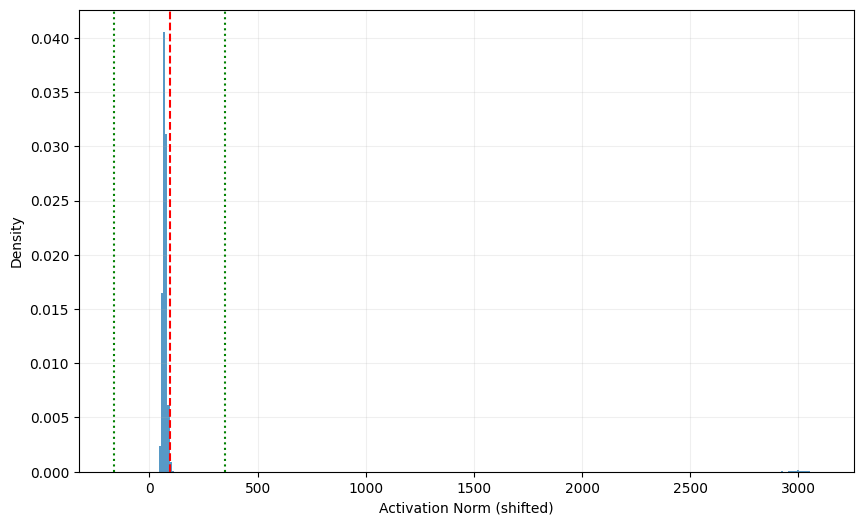

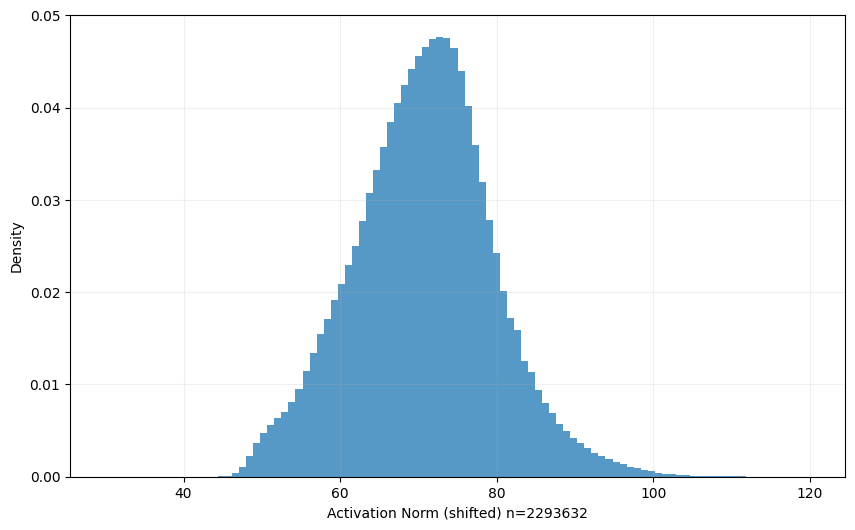

In [16]:
plot_histogram(norms_N)
plot_histogram_bounded(norms_N)